# Tensorflow Tutorial on Using CNN to Train MNIST Dataset

In [1]:
# The following line turns off the GPU
%env CUDA_VISIBLE_DEVICES=""

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

env: CUDA_VISIBLE_DEVICES=""


## Load MNIST dataset downloaded from http://yann.lecun.com/exdb/mnist/
- the data file is idx file format
- Don't bother to learn what the format is, use the functions we create to tranform data into numpy arrays
- However, be sure to understand the content of numpy arrays

### Understand the content of loaded image
- We have two set of data: train set with 60000 images, test set with 100000 images
- the image size is 28 x 28, the numerical range is **normalized** to [0, 255]
- the labels are intergers from 0 to 9

Loaded of train set has an array of shape (60000, 28, 28) for images, (60000, 28, 28) for labels
Loaded of test set has an array of shape (10000, 28, 28)  for images, (10000, 1) for labels
The values of 10th label: [3]
The values of 10th image:
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  42. 118. 219. 166. 118. 118.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0

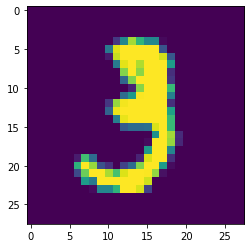

In [2]:
def extract_image(file):
    """Extract the (normalized) image from the idx file"""
    with open(file, "rb") as stream:
        stream.read(4) # header
        n_images = int.from_bytes(stream.read(4), byteorder="big")
        n_row = int.from_bytes(stream.read(4), byteorder="big")
        n_col = int.from_bytes(stream.read(4), byteorder="big")
        buf = stream.read(n_row * n_col * n_images)
        data = np.frombuffer(buf, np.uint8).astype(np.float32)
        data = data.reshape(n_images, n_row, n_col)
        return data


def extract_label(file):
    """Extract the label from the idx file"""
    with open(file, "rb") as stream:
        stream.read(4) # header
        n_labels = int.from_bytes(stream.read(4), byteorder="big")
        buf = stream.read(n_labels)
        data = np.frombuffer(buf, np.uint8)
        data = data.reshape(n_labels, 1)
        return data
    

all_train_images, all_train_labels = extract_image("./data/train-images.idx3-ubyte"), extract_label("./data/train-labels.idx1-ubyte")
test_images, test_labels = extract_image("./data/t10k-images.idx3-ubyte"), extract_label("./data/t10k-labels.idx1-ubyte")

print(f"Loaded of train set has an array of shape {all_train_images.shape} for images, {all_train_images.shape} for labels")
print(f"Loaded of test set has an array of shape {test_images.shape}  for images, {test_labels.shape} for labels")

np.set_printoptions(precision=2, suppress=True, linewidth=150, threshold=np.inf)

print(f"The values of 10th label: {all_train_labels[10, ...]}")
print(f"The values of 10th image:")
print(all_train_images[10, ...])

%matplotlib inline
plt.imshow(all_train_images[10, ...])

## Preprocess Loaded Data before Training

- Rescale the data into numerical ranges suitable for models (here we rescale to [0.0, 1.0])
- Split part of the training data into train/validation set
- One-hot the labels for calculating the cross-entropy loss

After split, train set has an array of shape (6000, 28, 28) for images, (6000, 10) for labels
After split, validation set has an array of shape (2000, 28, 28) for images, (2000, 10) for labels
The values of 10th label in train set after split: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
The values of 10th image in train set after split:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

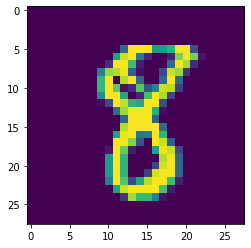

In [3]:
# Normalize the input data
all_train_images = all_train_images / 255
test_images = test_images / 255

# One-hot the label (credit: https://stackoverflow.com/questions/29831489/)
def one_hot(array, num_classes):
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

all_train_labels = one_hot(all_train_labels, 10)
test_labels = one_hot(test_labels, 10)

def random_shuffle(images, labels):
    assert images.shape[0] == labels.shape[0]
    n_data = images.shape[0]
    indices = np.random.permutation(n_data)
    return images[indices, ...], labels[indices, ...]

# Random shuffle and select 6000 images for train, 2000 images for validation
shuffled_images, shuffled_labels = random_shuffle(all_train_images, all_train_labels)
train_images, validation_images = shuffled_images[:6000, ...], shuffled_images[6000:8000, ...]
train_labels, validation_labels = shuffled_labels[:6000, ...], shuffled_labels[6000:8000:, ...]

print(f"After split, train set has an array of shape {train_images.shape} for images, {train_labels.shape} for labels")
print(f"After split, validation set has an array of shape {validation_images.shape} for images, {validation_labels.shape} for labels")

print(f"The values of 10th label in train set after split: {train_labels[10, ...]}")
print(f"The values of 10th image in train set after split:")
print(train_images[10, ...])

plt.imshow(train_images[10, ...])

## Create a Super Simple Convolution Network (CNN)

In [8]:
from tensorflow.keras.layers import InputLayer, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import Flatten, Dense
tiny_cnn = tf.keras.Sequential()
tiny_cnn.add(InputLayer(input_shape=(28, 28)))
tiny_cnn.add(Reshape(target_shape=(28, 28, 1)))  # Reshape the input as Conv2D layers expect intputs be (h, w, c), 
                                                 # where c is the number of channels of the images
tiny_cnn.add(Conv2D(filters=4, kernel_size=3, padding="same"))
tiny_cnn.add(MaxPool2D(pool_size=(2, 2)))
tiny_cnn.add(Conv2D(filters=8, kernel_size=3, padding="same"))
tiny_cnn.add(MaxPool2D(pool_size=(2, 2)))
tiny_cnn.add(Flatten())
tiny_cnn.add(Dense(units=32, activation="relu"))
tiny_cnn.add(Dense(units=10, activation="softmax"))
tiny_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

## Training the CNN

In [9]:
n_epochs = 100
n_batch = 1024
batch_per_epoch = train_images.shape[0] // n_batch

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def single_iteration(data, label):
    with tf.GradientTape() as tp:
        logits = tiny_cnn(data, training=True)
        loss = loss_fn(label, logits)
        
    grads = tp.gradient(loss, tiny_cnn.trainable_weights)
    optimizer.apply_gradients(zip(grads, tiny_cnn.trainable_weights))
    train_metrics.update_state(label, logits)
    return loss

@tf.function
def validation():
    logits = tiny_cnn(validation_images, training=False)
    loss = loss_fn(validation_labels, logits)
    validation_metrics.update_state(validation_labels, logits)
    acc = validation_metrics.result()
    validation_metrics.reset_states()
    return loss, acc

histroy = {
    "train_losses": [],
    "train_accs": [],
    "validation_losses": [],
    "validation_accs": []
}
for epoch in range(n_epochs):
    train_images, train_labels = random_shuffle(train_images, train_labels) # Reshuffle data
    train_metrics.reset_states()
    train_loss = 0.0

    for batch in range(batch_per_epoch):
        # Sample Batch
        batch_image = train_images[batch * n_batch: (batch + 1) * n_batch, ...]
        batch_label = train_labels[batch * n_batch: (batch + 1) * n_batch, ...]
        loss = single_iteration(batch_image, batch_label)
        train_loss += loss.numpy()
    
    # Display accuracy at the end of each epoch.
    validation_loss, validation_acc = validation()
    validation_loss = validation_loss.numpy()
    validation_acc = float(validation_acc)
    train_loss = train_loss / batch_per_epoch
    train_acc = float(train_metrics.result())
    train_msg = f"Train Loss/Acc {train_loss}/{train_acc} "
    validation_msg = f"Validation Loss/Acc  {validation_loss}/{validation_acc}"
    print(f"Epoch {epoch} -- {train_msg}; {validation_msg}")

    histroy["train_losses"].append(train_loss)
    histroy["train_accs"].append(train_acc)
    histroy["validation_losses"].append(validation_loss)
    histroy["validation_accs"].append(validation_acc)

Epoch 0 -- Train Loss/Acc 2.3136271476745605/0.14335937798023224 ; Validation Loss/Acc  2.306246042251587/0.13650000095367432
Epoch 1 -- Train Loss/Acc 2.3067907333374023/0.15000000596046448 ; Validation Loss/Acc  2.300095319747925/0.14300000667572021
Epoch 2 -- Train Loss/Acc 2.300580310821533/0.15449218451976776 ; Validation Loss/Acc  2.2941977977752686/0.15199999511241913
Epoch 3 -- Train Loss/Acc 2.295073127746582/0.1591796875 ; Validation Loss/Acc  2.2885825634002686/0.1550000011920929
Epoch 4 -- Train Loss/Acc 2.2896755218505858/0.16621093451976776 ; Validation Loss/Acc  2.2833571434020996/0.1615000069141388
Epoch 5 -- Train Loss/Acc 2.2835232257843017/0.16796875 ; Validation Loss/Acc  2.2781500816345215/0.1655000001192093
Epoch 6 -- Train Loss/Acc 2.2773155212402343/0.17578125 ; Validation Loss/Acc  2.2731454372406006/0.16899999976158142
Epoch 7 -- Train Loss/Acc 2.271732139587402/0.17910155653953552 ; Validation Loss/Acc  2.2679450511932373/0.17399999499320984
Epoch 8 -- Train 

Epoch 67 -- Train Loss/Acc 0.6447107195854187/0.8138672113418579 ; Validation Loss/Acc  0.6437309384346008/0.8180000185966492
Epoch 68 -- Train Loss/Acc 0.6368813514709473/0.8187500238418579 ; Validation Loss/Acc  0.6309160590171814/0.8230000138282776
Epoch 69 -- Train Loss/Acc 0.6173669695854187/0.824999988079071 ; Validation Loss/Acc  0.6186566948890686/0.8209999799728394
Epoch 70 -- Train Loss/Acc 0.6082501530647277/0.826367199420929 ; Validation Loss/Acc  0.6056770086288452/0.8264999985694885
Epoch 71 -- Train Loss/Acc 0.5958845257759094/0.829296886920929 ; Validation Loss/Acc  0.5938531756401062/0.8295000195503235
Epoch 72 -- Train Loss/Acc 0.5853232502937317/0.831835925579071 ; Validation Loss/Acc  0.58344966173172/0.8324999809265137
Epoch 73 -- Train Loss/Acc 0.5826790809631348/0.830078125 ; Validation Loss/Acc  0.5738587379455566/0.8360000252723694
Epoch 74 -- Train Loss/Acc 0.5612711906433105/0.8363281488418579 ; Validation Loss/Acc  0.5649955868721008/0.8339999914169312
Epoch

## Examin the Loss Curves / Accuracy Curves

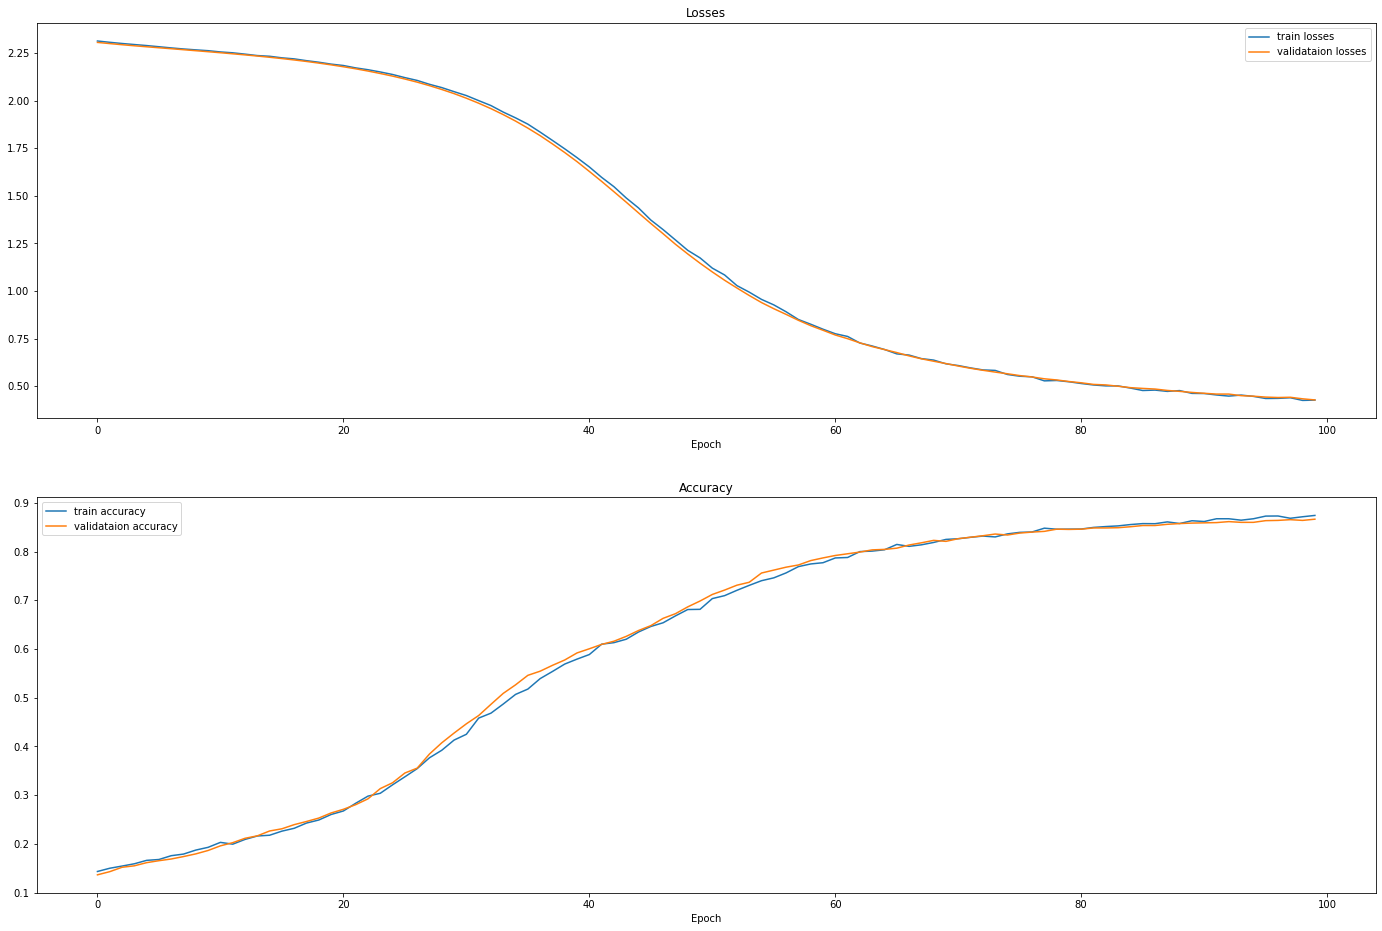

In [10]:
%matplotlib inline

fig = plt.figure(figsize=[24, 16])
ax = plt.subplot(211)
ax.plot(np.array(histroy["train_losses"]), label="train losses")
ax.plot(np.array(histroy["validation_losses"]), label="validataion losses")
ax.set_xlabel("Epoch")
ax.set_title("Losses")
ax.legend()

ax = plt.subplot(212)
ax.plot(np.array(histroy["train_accs"]), label="train accuracy")
ax.plot(np.array(histroy["validation_accs"]), label="validataion accuracy")
ax.set_xlabel("Epoch")
ax.set_title("Accuracy")
ax.legend()

## Evaluate Data on Test Set

Test Set Loss 0.413409948348999, Acc 0.8794999718666077
Evaluate on this specific image, model predicts 7:


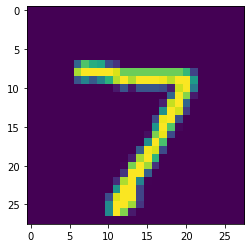

In [15]:
logits = tiny_cnn(test_images, training=False)
test_loss = loss_fn(test_labels, logits).numpy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics.update_state(test_labels, logits)
test_acc = float(test_metrics.result())
test_metrics.reset_states()
print(f"Test Set Loss {test_loss}, Acc {test_acc}")

example_image = test_images[0, ...]
prediction = tiny_cnn(example_image[np.newaxis, ...], training=False).numpy()
prediction = np.argmax(prediction)
print(f"Evaluate on this specific image, model predicts {prediction}:")
plt.imshow(example_image)